# Projecting CD71+ cells on HSC/MPP PB reference cells

In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

import os, sys, math, re
import natsort, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import scanpy as sc
import scanpy.external as sce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'metztli.25j'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
home = str(Path.home())
user = getpass.getuser()

In [5]:
"""
Allows to create a persistent png image from
the last plotted matplotlib plot widget
"""
def perma_plot():
    
    import base64
    from io import BytesIO
    from IPython.display import HTML
    
    # TODO: maybe pass parameters for savefig
    #       to control quality/type of img
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    encoded_string = base64.b64encode(buffer.read()).decode('utf-8')
    html_string = '<img src=\'data:image/png;base64,{}\'>'.format(encoded_string)
    
    return HTML(html_string)

---

In [6]:
basedir = os.path.join(home, 'databoard/users', user)

sc.settings.writedir = os.path.join(basedir, '2021/BloodPaper/h5ad/')

---

---

In [7]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20211203


### Create anndata object for PB110 cells

In [8]:
counts = pd.read_csv('2019/XTRAS/PB110/input/SLX-17054_combined_HTcounts.txt', sep='\t')
counts.head()

,ID,SLX.17054.i701_i502,SLX.17054.i701_i503,SLX.17054.i701_i504,SLX.17054.i701_i505,SLX.17054.i701_i506,SLX.17054.i701_i507,SLX.17054.i701_i508,SLX.17054.i701_i517,SLX.17054.i702_i502,...,SLX.17054.i728_i521,SLX.17054.i728_i522,SLX.17054.i729_i513,SLX.17054.i729_i515,SLX.17054.i729_i516,SLX.17054.i729_i517,SLX.17054.i729_i518,SLX.17054.i729_i520,SLX.17054.i729_i521,SLX.17054.i729_i522
0,ENSG00000000003,0,0,0,0,1,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,0,1,0,1,347,0,0,0,0,...,0,0,0,0,788,0,0,0,0,0
3,ENSG00000000457,10,0,0,0,0,1,0,0,669,...,0,0,0,0,0,1,0,0,0,0
4,ENSG00000000460,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
meta = pd.read_csv('2019/XTRAS/PB110/input/PB110_270219_Metadata.csv')
meta.head()

,ID,Sample_ID,CRI_identifier,CRI_run,Plate_number,Position_in_96_well_plate_sorted,Position_in_96_well_plate_RNA-seq,FACs_index_data,Sample_name,Details,...,CD90_PE,CD38_PC7,CD45RA_A700,CD34_APC-Cy7,CD71_FITC,CD41a_BV510,CD36_APC,CD105_BV650,CD123_BV785,Zombie_UV
0,SLX.17054.i701_i502,El4000,SLX.17054,SCACCF-Laurenti_#14,Plate_1,A1,A1,Yes,BP45k,CD71hi,...,-10,-178,4,"6,062","2,040",-311,-123,150,575,762
1,SLX.17054.i702_i502,El4001,SLX.17054,SCACCF-Laurenti_#14,Plate_1,A2,A2,Yes,BP45k,CD71hi,...,5,336,33,"5,518","2,115","1,490",369,156,301,547
2,SLX.17054.i703_i502,El4002,SLX.17054,SCACCF-Laurenti_#14,Plate_1,A3,A3,Yes,BP45k,CD71hi,...,-23,267,-55,"4,203","1,936","12,243","3,389",981,-24,881
3,SLX.17054.i704_i502,El4003,SLX.17054,SCACCF-Laurenti_#14,Plate_1,A4,A4,Yes,BP45k,CD71hi,...,-8,367,109,"5,948","4,984",-56,-215,401,901,520
4,SLX.17054.i705_i502,El4004,SLX.17054,SCACCF-Laurenti_#14,Plate_1,A5,A5,Yes,BP21j,CD71hi,...,870,960,25,"6,072","2,425",-447,-125,25,-50,551


In [10]:
meta.shape

(192, 32)

In [11]:
counts.shape

(66085, 193)

In [12]:
temp = sc.read('20211117_COMBO10_original_standard_working_clean_version')

In [13]:
temp.obs.head()

,batch,n_counts,n_genes,mitoc_fraction,doublet_score,library,donor,organ,leiden.1.2,silhouette.1.2,dpt_pseudotime,dpt_pseudotime_rank,S_score,G2M_score,phase,annot
_01_AAACCTGCACGTCTCT.1.0,0,10052.0,2399,0.027491,0.054662,SIGAD9,DOD1,PB,2,-0.095935,0.224698,66554.0,-0.156682,-0.062280,G1,02_MEP2
_01_AAACCTGGTGTGACGA.1.0,0,14884.0,3610,0.030734,0.011152,SIGAD9,DOD1,PB,13,0.295117,0.396628,85875.0,0.383165,0.065524,S,13_MEP cycle
_01_AAACCTGGTTCCGGCA.1.0,0,5547.0,1544,0.042304,0.021956,SIGAD9,DOD1,PB,0,0.198961,0.082326,23761.0,-0.166414,-0.085699,G1,00_HSC/MPP2
_01_AAACGGGGTCAAAGCG.1.0,0,4184.0,1159,0.026033,0.031721,SIGAD9,DOD1,PB,0,0.031663,0.097205,34985.0,-0.096252,-0.099328,G1,00_HSC/MPP2
_01_AAAGATGCACATGACT.1.0,0,12027.0,2548,0.027215,0.096179,SIGAD9,DOD1,PB,0,0.034625,0.093352,32259.0,-0.135317,-0.064835,G1,00_HSC/MPP2


In [14]:
ref = temp[ np.logical_and(temp.obs.organ == 'PB', temp.obs['leiden.1.2'].isin(['4', '0', '5', '11', '21']) ), : ].copy()

In [17]:
mapping = ref.var[['gene_ids']]
mapping['gene_name'] = ref.var.index

In [20]:
annot_counts = pd.merge(mapping, counts, left_on='gene_ids', right_on='ID', how='right')

In [22]:
annot_counts = annot_counts[ ~annot_counts.gene_name.isna() ].copy()

In [23]:
import anndata

In [34]:
columns = [ list(annot_counts.columns)[1] ] + list(annot_counts.columns)[3:]

In [37]:
df = annot_counts.loc[ :, list(annot_counts.columns)[3:] ]
df.index = annot_counts.loc[:, 'gene_name']
df.head()

,SLX.17054.i701_i502,SLX.17054.i701_i503,SLX.17054.i701_i504,SLX.17054.i701_i505,SLX.17054.i701_i506,SLX.17054.i701_i507,SLX.17054.i701_i508,SLX.17054.i701_i517,SLX.17054.i702_i502,SLX.17054.i702_i503,...,SLX.17054.i728_i521,SLX.17054.i728_i522,SLX.17054.i729_i513,SLX.17054.i729_i515,SLX.17054.i729_i516,SLX.17054.i729_i517,SLX.17054.i729_i518,SLX.17054.i729_i520,SLX.17054.i729_i521,SLX.17054.i729_i522
gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0,0,0,0,1,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
DPM1,0,1,0,1,347,0,0,0,0,136,...,0,0,0,0,788,0,0,0,0,0
SCYL3,10,0,0,0,0,1,0,0,669,0,...,0,0,0,0,0,1,0,0,0,0
C1orf112,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
FGR,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,1427,0,0,0,0,0


In [40]:
data = anndata.AnnData(df.T)

In [50]:
temp = annot_counts.loc[:, ['gene_name', 'gene_ids'] ]

In [53]:
temp.index = temp.loc[: , 'gene_name']
temp.head()

,gene_name,gene_ids
gene_name,,
TSPAN6,TSPAN6,ENSG00000000003
DPM1,DPM1,ENSG00000000419
SCYL3,SCYL3,ENSG00000000457
C1orf112,C1orf112,ENSG00000000460
FGR,FGR,ENSG00000000938


In [54]:
data.var['gene_id'] = temp.loc[:, 'gene_ids']

In [55]:
data.var.head()

,gene_id
gene_name,
TSPAN6,ENSG00000000003
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460
FGR,ENSG00000000938


In [58]:
intense = meta[['ID', 'Sample_name', 'FSC-A',
       'FSC-W', 'SSC-A', 'CD90_PE', 'CD38_PC7', 'CD45RA_A700', 'CD34_APC-Cy7',
       'CD71_FITC', 'CD41a_BV510', 'CD36_APC', 'CD105_BV650', 'CD123_BV785',
       'Zombie_UV']].copy()

In [61]:
intense.index = intense.loc[:, 'ID']

In [63]:
intense.drop('ID', inplace=True, axis=1)

In [65]:
intense.index.name = None

In [66]:
intense.head()

,Sample_name,FSC-A,FSC-W,SSC-A,CD90_PE,CD38_PC7,CD45RA_A700,CD34_APC-Cy7,CD71_FITC,CD41a_BV510,CD36_APC,CD105_BV650,CD123_BV785,Zombie_UV
SLX.17054.i701_i502,BP45k,"115,440","83,855","26,079",-10,-178,4,"6,062","2,040",-311,-123,150,575,762
SLX.17054.i702_i502,BP45k,"116,050","82,863","23,729",5,336,33,"5,518","2,115","1,490",369,156,301,547
SLX.17054.i703_i502,BP45k,"116,117","83,975","25,922",-23,267,-55,"4,203","1,936","12,243","3,389",981,-24,881
SLX.17054.i704_i502,BP45k,"99,032","79,703","17,388",-8,367,109,"5,948","4,984",-56,-215,401,901,520
SLX.17054.i705_i502,BP21j,"97,763","80,090","15,911",870,960,25,"6,072","2,425",-447,-125,25,-50,551


In [71]:
data.obs = intense.loc[ data.obs.index , :].copy()

In [72]:
data

AnnData object with n_obs × n_vars = 192 × 23603
    obs: 'Sample_name', 'FSC-A', 'FSC-W', 'SSC-A', 'CD90_PE', 'CD38_PC7', 'CD45RA_A700', 'CD34_APC-Cy7', 'CD71_FITC', 'CD41a_BV510', 'CD36_APC', 'CD105_BV650', 'CD123_BV785', 'Zombie_UV'
    var: 'gene_id'

In [74]:
print(prefix+'_PB110_dataset')

20211203_PB110_dataset


In [76]:
sc.write(prefix+'_PB110_dataset', data)

... storing 'Sample_name' as categorical
... storing 'FSC-A' as categorical
... storing 'FSC-W' as categorical
... storing 'SSC-A' as categorical
... storing 'CD90_PE' as categorical
... storing 'CD38_PC7' as categorical
... storing 'CD34_APC-Cy7' as categorical
... storing 'CD71_FITC' as categorical
... storing 'CD41a_BV510' as categorical
... storing 'CD36_APC' as categorical
... storing 'CD105_BV650' as categorical
... storing 'CD123_BV785' as categorical


---

### Process PB110 anndata object

In [77]:
%%time
sc.pl.highest_expr_genes(data, n_top=20)

normalizing counts per cell
    finished (0:00:00)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

CPU times: user 149 ms, sys: 9.6 ms, total: 158 ms
Wall time: 155 ms



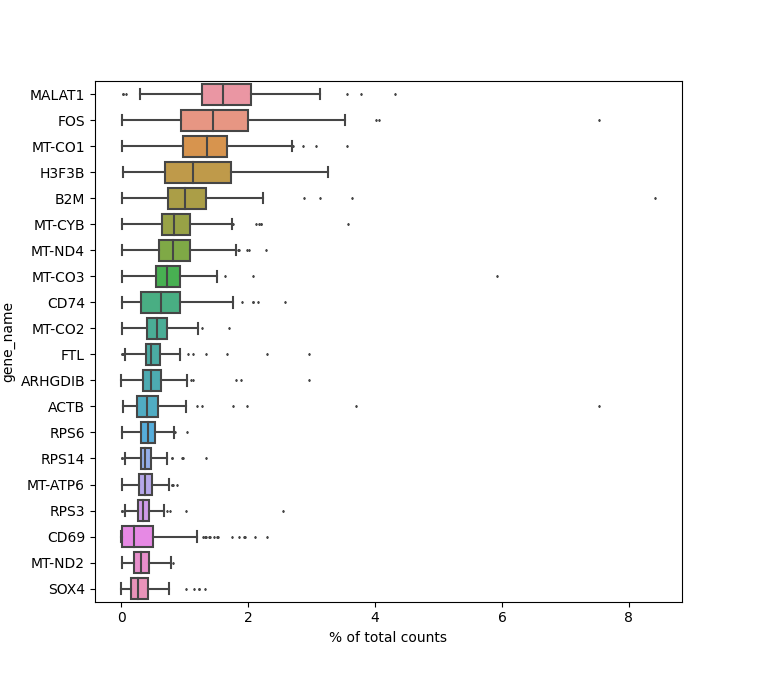

In [78]:
perma_plot()

Save raw counts in its own layer

In [79]:
data.layers['counts'] = data.X.copy()

In [81]:
# add the total counts per cell as sample annotation to adata
data.obs['n_counts'] = np.sum(data.X, axis=1)
data.obs['n_counts_log'] = np.log10(np.sum(data.X, axis=1))

In [83]:
# add the total of non-zero genes for each cell
data.obs['n_genes'] = np.count_nonzero(data.X, axis=1)

In [84]:
import re

In [85]:
mitoc_genes = np.array([name for name in data.var_names
                       if bool(re.search("^MT-", name))])
# for each cell compute fraction of counts in mito genes vs. all genes
data.obs['mitoc_fraction'] = np.sum(data[:, mitoc_genes].layers['counts'], axis=1) / np.sum(data.layers['counts'], axis=1)

In [89]:
norm = plt.Normalize(data.obs['mitoc_fraction'].min(), data.obs['mitoc_fraction'].max())
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])

In [91]:
fig, ax = plt.subplots(1,2, figsize=(14,5) )

sns.scatterplot(x='n_counts', y='n_genes', data=data.obs, hue='mitoc_fraction', ec=None, ax=ax[0])

ax[1].scatter(data.obs['n_counts'], data.obs['mitoc_fraction'], c='lightgrey', s=1.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
for a in ax[0].collections: # although only first ('0') collection seems to be the actual points
    a.set_sizes([5])

# Remove the legend and add a colorbar (optional)
ax[0].get_legend().remove()
fig.colorbar(sm, ax=ax[0], shrink=0.95)

ax[0].axes.set_ylabel('Number of genes')

ax[0].axes.set_xlabel('')
ax[1].axes.set_ylabel('Fraction of mitochondrial genes')

fig.text(0.5, 0.01, 'Count depth', ha='center', va='center')

Text(0.5, 0.01, 'Count depth')


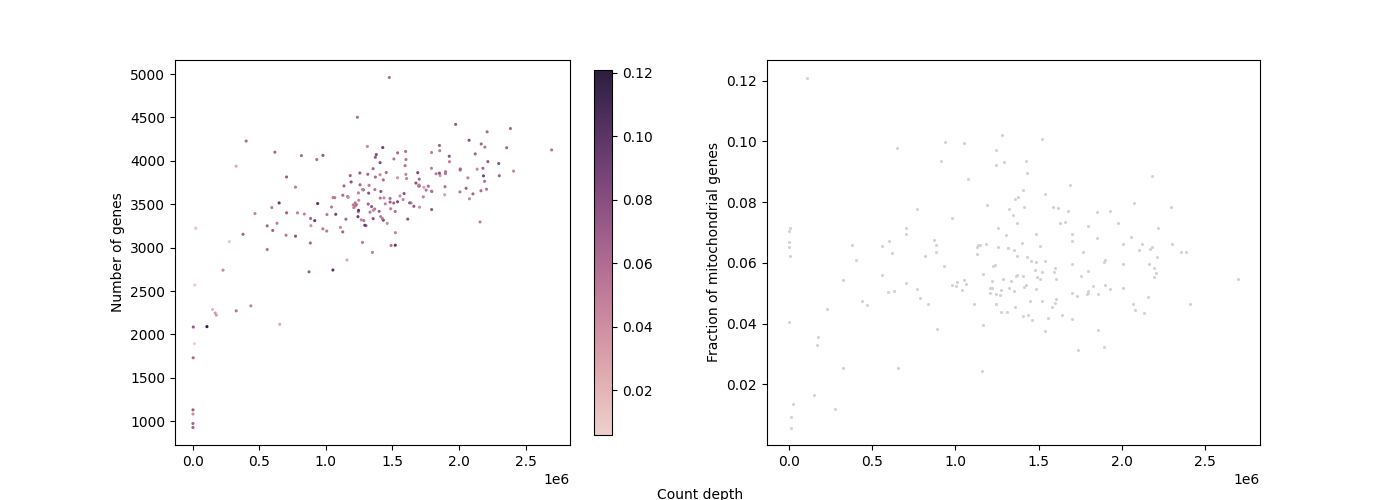

In [93]:
perma_plot()

In [95]:
data.obs.head()

,Sample_name,FSC-A,FSC-W,SSC-A,CD90_PE,CD38_PC7,CD45RA_A700,CD34_APC-Cy7,CD71_FITC,CD41a_BV510,CD36_APC,CD105_BV650,CD123_BV785,Zombie_UV,n_counts,n_counts_log,n_genes,mitoc_fraction
SLX.17054.i701_i502,BP45k,"115,440","83,855","26,079",-10,-178,4,"6,062","2,040",-311,-123,150,575,762,401432.0,5.603612,4228,0.060857
SLX.17054.i701_i503,BP45k,"103,729","80,877","25,706",9,391,97,"5,504","1,678","11,876","7,588",116,237,683,559008.0,5.747418,3251,0.065643
SLX.17054.i701_i504,BP45k,"109,626","81,787","19,350",-36,90,21,"6,430","1,432",-39,-143,307,-30,461,377255.0,5.576635,3154,0.065778
SLX.17054.i701_i505,BP45k,"103,457","80,588","23,791",-60,208,-70,"4,976","1,655","8,932","2,538",200,925,666,771695.0,5.887446,3697,0.051553
SLX.17054.i701_i506,BP45k,"110,856","81,661","19,939",-9,204,147,"5,807","2,934",-256,-33,143,321,507,467521.0,5.669801,3393,0.045985


In [96]:
data.obs.groupby('Sample_name').size()

Sample_name
BP19d    64
BP21j    63
BP45k    63
empty     1
emtpy     1
dtype: int64

In [100]:
data[data.obs.Sample_name.isin( ['empty', 'emtpy'] ) , :]

View of AnnData object with n_obs × n_vars = 2 × 23603
    obs: 'Sample_name', 'FSC-A', 'FSC-W', 'SSC-A', 'CD90_PE', 'CD38_PC7', 'CD45RA_A700', 'CD34_APC-Cy7', 'CD71_FITC', 'CD41a_BV510', 'CD36_APC', 'CD105_BV650', 'CD123_BV785', 'Zombie_UV', 'n_counts', 'n_counts_log', 'n_genes', 'mitoc_fraction'
    var: 'gene_id'
    layers: 'counts'

In [103]:
data = data[~data.obs.Sample_name.isin( ['empty', 'emtpy'] ) , :].copy()

In [111]:
data = data[ :, data.X.sum(axis=0) > 0 ].copy()

In [112]:
data.shape

(190, 20718)

In [113]:
sc.pp.normalize_total(data, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [114]:
data

AnnData object with n_obs × n_vars = 190 × 20718
    obs: 'Sample_name', 'FSC-A', 'FSC-W', 'SSC-A', 'CD90_PE', 'CD38_PC7', 'CD45RA_A700', 'CD34_APC-Cy7', 'CD71_FITC', 'CD41a_BV510', 'CD36_APC', 'CD105_BV650', 'CD123_BV785', 'Zombie_UV', 'n_counts', 'n_counts_log', 'n_genes', 'mitoc_fraction'
    var: 'gene_id'
    layers: 'counts'

In [115]:
sc.pp.log1p(data, base=2)

In [116]:
data.layers["lognorm"] = data.X.copy()

In [118]:
np.min(data.X), np.max(data.X)

(0.0, 10.491318)

In [159]:
sc.write(prefix+'_PB110_dataset_lognorm', data)

### Project cells (PB110 on Seurat reintegrated PB HSC/MPPs reference)

---

In [8]:
target = sc.read('20211203_PB110_dataset_lognorm')

In [9]:
integrated = sc.read('20211203_COMBO_only_PB_HSCMPP_Seurat3_VST_classic_integrated')

In [10]:
integrated

AnnData object with n_obs × n_vars = 14978 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'batch', 'n_counts', 'n_genes', 'mitoc_fraction', 'doublet_score', 'library', 'donor', 'organ', 'leiden.1.2', 'silhouette.1.2', 'dpt_pseudotime', 'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase', 'annot'

In [16]:
integrated.X.min(), integrated.X.max()

(-2.7191498, 7.4536734)

In [17]:
integrated.layers['seurat'] = integrated.X.copy()

In [18]:
sc.pp.scale(integrated)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [19]:
integrated.X.min(), integrated.X.max()

(-12.757464, 55.74442)

In [20]:
sc.tl.pca(integrated, n_comps=30)

computing PCA
    with n_comps=30
    finished (0:00:04)


In [21]:
sc.pl.embedding(integrated, basis='pca', color=['donor'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
plt.subplots_adjust(right=.8)


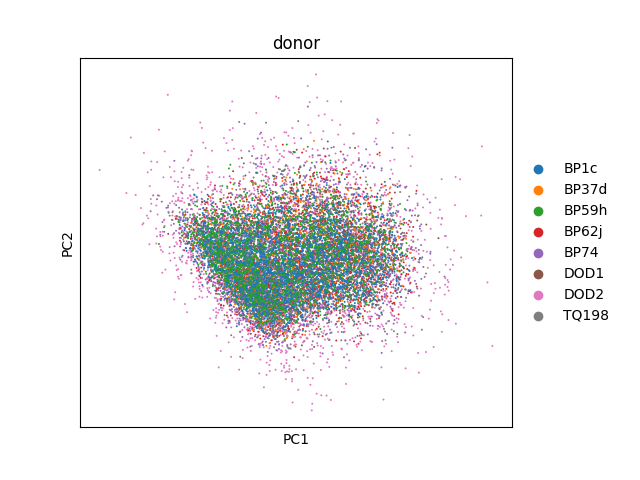

In [23]:
perma_plot()

In [26]:
sc.pp.neighbors(integrated)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


In [28]:
sc.tl.umap(integrated)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [29]:
sc.pl.embedding(integrated, basis='umap', color='donor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
plt.subplots_adjust(right=.8)


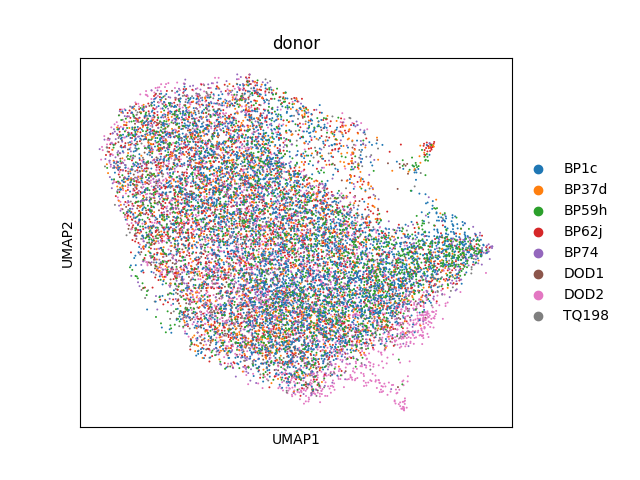

In [31]:
perma_plot()

In [45]:
%%time
sc.write(prefix+'_COMBO_only_PB_HSCMPP_Seurat_classic_integration_Scanpy_downstream_processed_basic', integrated)

CPU times: user 11.3 s, sys: 344 ms, total: 11.7 s
Wall time: 11.8 s


In [46]:
import cellproject_master.cellproject as cp

In [48]:
ref = integrated[:, integrated.var_names.intersection(target.var_names)].copy()

target = target[:, integrated.var_names.intersection(target.var_names)].copy()

In [50]:
ref.shape, target.shape

((14978, 1932), (190, 1932))

In [51]:
%%time
umap_ref = cp.quick_umap(ref, rep_n_components=30)

CPU times: user 13.4 s, sys: 641 ms, total: 14.1 s
Wall time: 11.1 s


In [52]:
def unclog_umap_caching(x) :
    
    import tempfile
    '''
    This is an ugly fix to allow fit_transform into an UMAP object,
    it gets rids of "TypeError: cannot pickle 'weakref' object" error
    Provide a UMAP object as x.
    IMPORTANT: this function will break the UMAP object, recompute
    afterwards.
    '''
    import pickle
    #  umap_ref._knn_search_index._visited = np.zeros((umap_ref._knn_search_index._raw_data.shape[0] // 8) + 1, dtype=np.uint8, order="C")
    for i in range(3):
        try:
            with tempfile.TemporaryFile() as f:
                pickle.dump(x, f)
        except:
            pass
    #  umap_ref._knn_search_index._vertex_order = umap_ref._knn_search_index._search_forest[0].indices

In [53]:
unclog_umap_caching(umap_ref)

In [54]:
umap_ref2 = cp.quick_umap(ref, rep_n_components=30)

In [55]:
%%time
cp.project_cells(target,
                  ref,
                  pca_n_components=None,
                  k=15,
                  obs_columns=['annot'],
                  fit_pca=True,
                  scale_data=True,
                  use_vargenes=False,
                  umap_ref=umap_ref2,
                  numeric_fun=np.mean,
                  categorical_how='mode',
                  copy=False)

Running a common scaling for target and reference data
Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
Using the provided UMAP reference to fit new data
CPU times: user 5.27 s, sys: 103 ms, total: 5.38 s
Wall time: 4.26 s


In [56]:
target.obs.groupby(['ref_annot']).size()

ref_annot
00_HSC/MPP2    171
04_HSC/MPP1      6
05_HSC/MPP3     10
11_HSC/MPP4      3
dtype: int64

In [61]:
target.obs['dataset'] = 'target'
ref.obs['dataset'] = 'ref'

In [69]:
target.obs.columns = list(target.obs.columns)[:-2] + [ 'annot', 'dataset' ]

In [71]:
comb = ref.concatenate(target)

In [100]:
sc.write(prefix+'_COMBO_only_PB_HSCMPP_plus_PB110_cp_annotated', comb)

In [162]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

sc.pl.embedding(comb, color='annot', ax=ax, legend_loc='on data', basis='umap', legend_fontsize='small')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [172]:
alpha = 0.3

ax.collections[0].get_facecolor()[:, 3] =  alpha

plt.draw()

In [166]:
sc.pl.embedding(comb[comb.obs.dataset == 'target', : ], color='annot', ax=ax, legend_loc=None, basis='umap')

In [171]:
ax.collections[1].set_sizes([30])


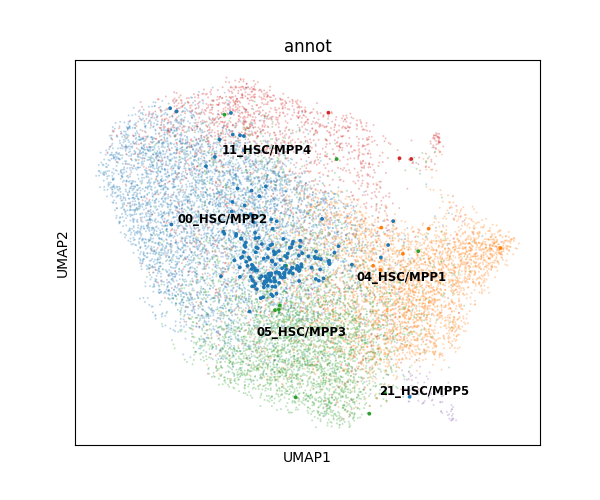

In [173]:
perma_plot()